In [1]:
from finetwork.data_collector import FinData
from finetwork.transformer import MarketCycle, Split, NetTransformer
from finetwork.distance_calculator import CalculateDistance
from finetwork.clusterer import NetClusterer
from finetwork.optimiser import Validator, Optimiser
from finetwork.plotter import Plotter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import json
import datetime
import statsmodels.api as sm
from bioinfokit.analys import stat
import seaborn as sns
import scipy.stats as stats
from statsmodels.formula.api import ols

import warnings
warnings.filterwarnings("ignore")

For the purpose of analysis one may want to identify the appropriate time intervals for selecting stocks to the investment portfolio and the following investment horizon. This can be done either by the means of expert estimations or using market-index based criterion values for identifying meaningful stages of market cycles. FiNetwork provides the functionality to evaluate these by plotting Wyckoff's stages of market cycle. This is done by calculating one of the criterion values (based on [Fei Ren et al., 2017]):
- "amplitude" criterion
- "trading day" criterion
- "and" criterion
- "or" criterion

Once the appropriate criterion and time window is determined, data can be splitted into corresponding time windows to 1) calculate distances based on correlations or dependecies among stocks in these time periods; and 2) to use these time windows as periods for estimation-investment horizons.

Let's first fix some date range for analysis as well as benchmark index, country of index, name of the market (needed to retrieve data using investpy library)

In [2]:
FROM_DATE='01/01/2010'
TO_DATE='30/12/2020'
BENCHMARK_INDEX = 'S&P 500'
COUNTRY = 'United States'
MARKET = 'world_indices'

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

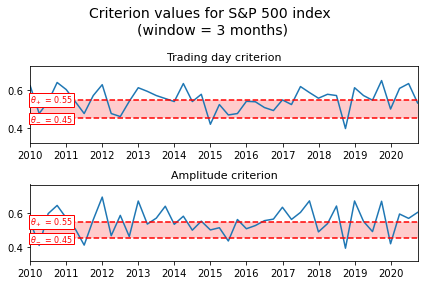

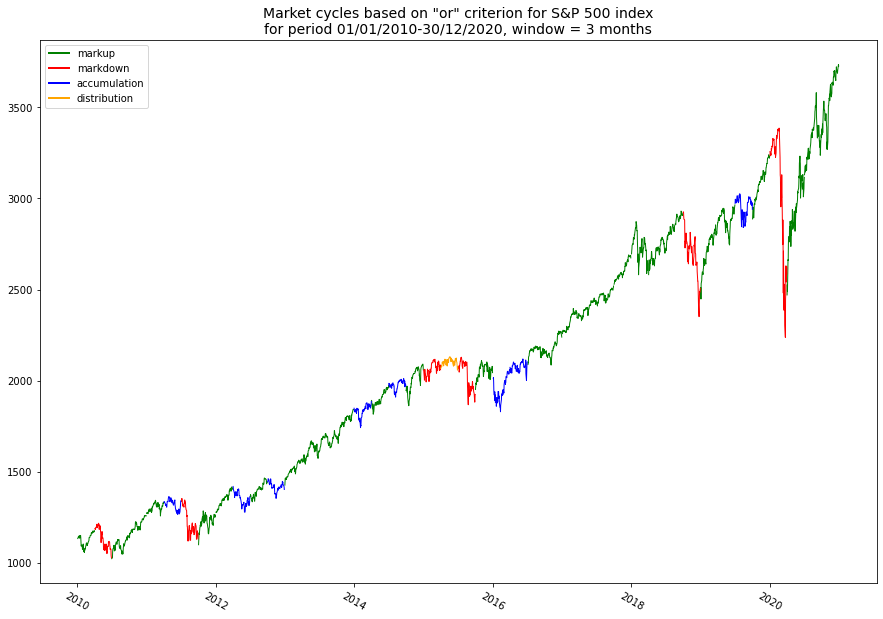

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

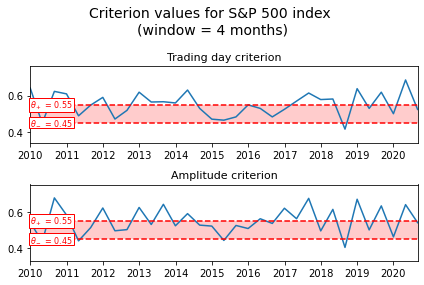

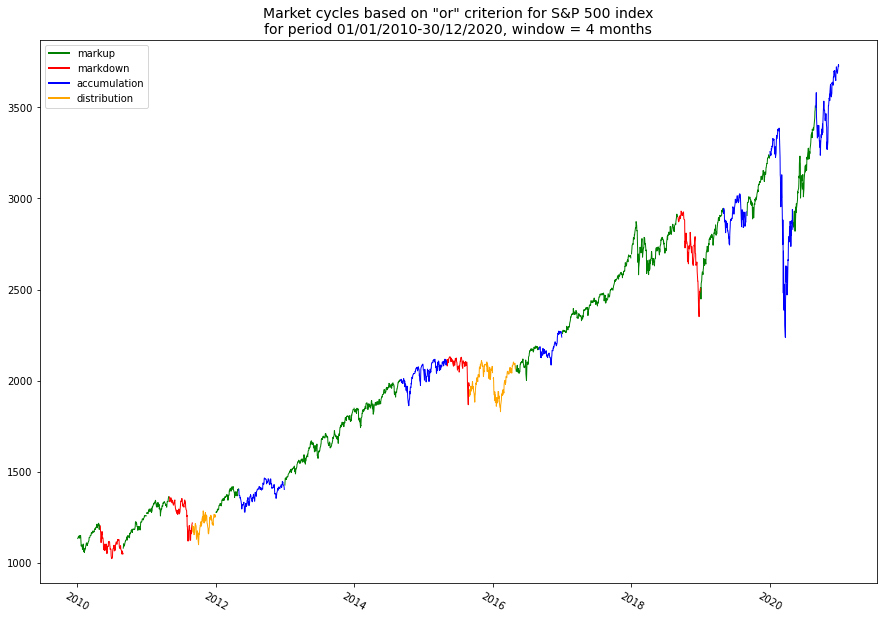

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

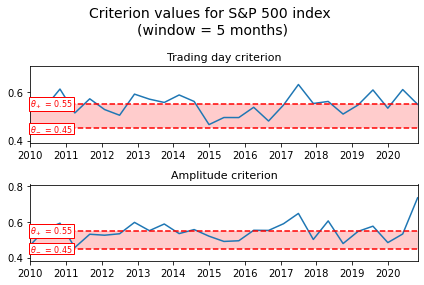

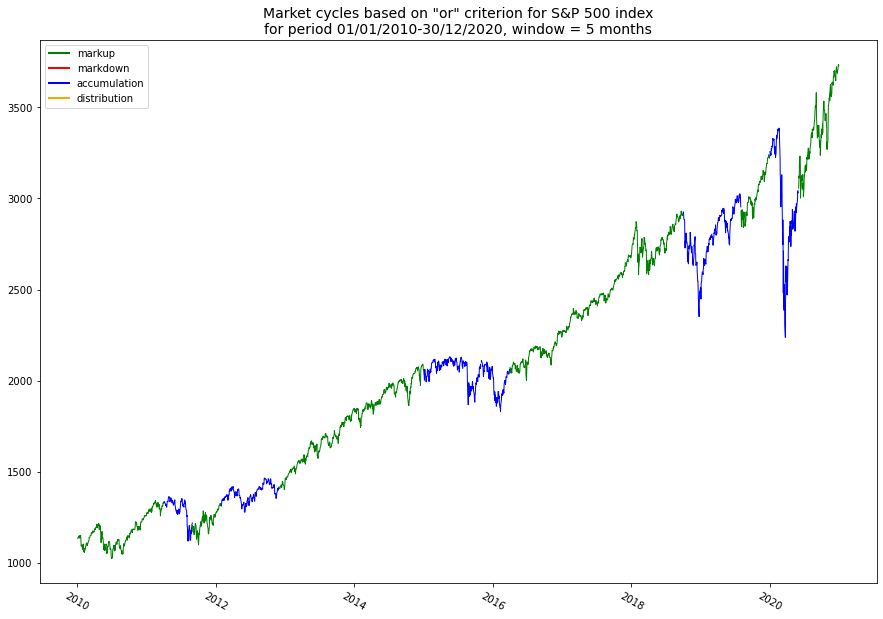

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

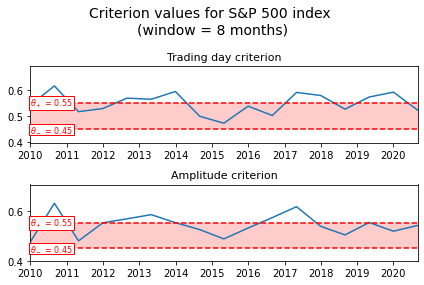

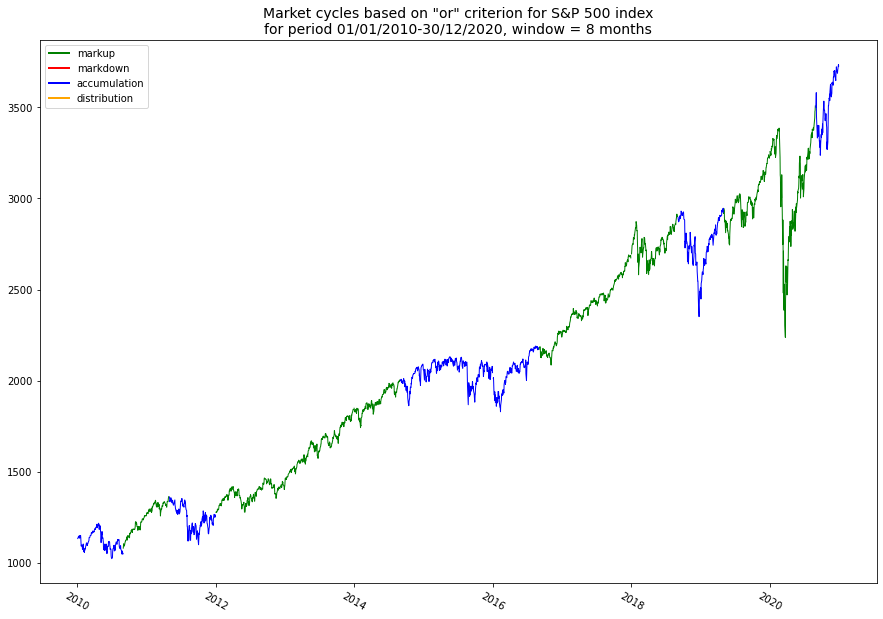

In [3]:
for param in [(3,'or'),
              (4, 'or'),
              (5, 'or'), 
              (8, 'or')]:
    mc = MarketCycle(
            benchmark_index=BENCHMARK_INDEX,
            from_date=FROM_DATE, 
            to_date=TO_DATE,
            country=COUNTRY,
            market=MARKET,
            criterion=param[1],
            window=param[0],
            theta_min=0.45,
            theta_max=0.55,
        )
    mc.plot_cycles()
    mc.plot_index_with_cycles(name=f'Index {BENCHMARK_INDEX} for {FROM_DATE}-{TO_DATE},'
                                  f' criterion={param[1]}, window={param[0]}', save=False)

According to the above plots it seems that the optimal time partition would be made based on "or" criterion with window = 4 month as it represents the underlying markt movements more precisely. You can try other criterion values and/or periods.

Now we can download data for stocks included in the S&P 500 index (be careful! if data is unavailable or lacking for a particular stock (meaning that the appropriate network analysis can't be conducted with limited data), it will be excluded automatically). 


Names of tickers should be organised in a list.

In [5]:
import random

sp500_companies = pd.read_csv(
    'https://raw.githubusercontent.com/datasets/'
    's-and-p-500-companies/master/data/constituents.csv'
)['Symbol']
sp500_companies = random.choices(sp500_companies, k=200)

In [6]:
sp500 = FinData(
    from_date=FROM_DATE,
    to_date=TO_DATE,
    tickers=sp500_companies,
    country=COUNTRY, 
    market = "NYSE"
)
sp500_data = sp500.get_data(save=False)

  0%|          | 0/200 [00:00<?, ?it/s]

Let's separate data from the dictionary into two separate variables, namely with data on industries the companies relate to and the the stock data itself.

In [7]:
sp500_industries = sp500_data['sectors']
sp500_data = sp500_data['data']

As you can see .get_data() method returns two dictionaries. The first one contains mapping between stocks and industries the company belongs to.

The second dictionary contains adjusted close prices and log returns for each datastamp

In [8]:
selected_data = sp500_data[list(sp500_data.keys())[0]]
{list(sp500_data.keys())[5]: {k: v for k,v in selected_data.items() if k in list(selected_data.keys())[:5]}}

{'SYY': {'2010-01-04 00:00:00': {'close_adj': 35.34330655959147,
   'log_return': nan},
  '2010-01-05 00:00:00': {'close_adj': 34.919987339038826,
   'log_return': -0.012049658335439695},
  '2010-01-06 00:00:00': {'close_adj': 34.881503773534064,
   'log_return': -0.0011026575160664187},
  '2010-01-07 00:00:00': {'close_adj': 34.29655357786141,
   'log_return': -0.01691184054077599},
  '2010-01-08 00:00:00': {'close_adj': 34.25037329925567,
   'log_return': -0.0013474064468343983}}}

Now we can split the stock data into time windows. 

In [9]:
sp500_split = Split(
    sp500_data, 
    from_date=FROM_DATE, 
    to_date=TO_DATE, 
    window_size=4
).transform()

Once the data is splited into time windows the distances among stocks for each period can be calculated. The distances matrix can be then used to construct the stock market network for further analysis.

In [10]:
sp500_dist = CalculateDistance(
    sp500_split,
    method='pearson',
    scaled=True
).transform()

Transformed data is the collection of dictionaries containing distance matrxes for each time window. 

Clustering analysis can be conducted on these graphs to identify communities in the stock market for each time period.

In [11]:
clustering_method = 'Kmeans'
nc = NetClusterer(
    method=clustering_method, 
    data_dict=sp500_dist,
    return_validation_scores=True
) 
cluster_results = nc.fit()

In [12]:
nc

NetClusterer object has a .print_scores() method returning the three score to estimate the clustering results quality.

In [13]:
nc.print_scores()

Kmeans clustering results
+------------------------------+----------+
| Metrics                      | Value    |
+------------------------------+----------+
| Mean calinski_harabasz_index | 117.3285 |
| Mean sillhouette_score       | 0.5832   |
| Mean davies_bouldin_score    | 0.6437   |
+------------------------------+----------+


We can now visualise the results as a dinamic graph saving it to .gif format. partition can be performed either for industries (providing the dict of mapping between stocks and industries) or for clusters (providing the dict with clustering results)

For a better visualisation it's considered a good practice to first filter the network. In FiNetwork you can do it witj one of the following methods:
- Minimum Spanning Tree (mst), or
- Planar Maximally Filtered Graph (pmfg)

In [14]:
nt = NetTransformer(method='mst')
filtered_data = nt.fit_transform(sp500_dist)

In [15]:
filtered_data[list(filtered_data.keys())[0]]

In [16]:
gplt = Plotter(data=filtered_data, 
        plot_type='circus', 
        partition={k:sp500_industries for k in sp500_dist.keys()},
# specify path if you want to save all the gif frames
#        path='industries'
              )
gplt.plot()

gplt.mgif(gif_name='industries_partition',
    duration=1000)

<img src="industries_partition.gif" width="1000" align="center">

In [17]:
gplt = Plotter(data=filtered_data, 
        plot_type='circus', 
        partition=cluster_results,
#        path='clusters'
              )
gplt.plot()

gplt.mgif(gif_name='clusters_partition',
    duration=1000)

<img src="clusters_partition.gif" width="1000" align="center">

Once the optimal clustering method is identified and clustering is conducted optimiser can be used to select the optimal portfolio either randomly, based on industries partition or based on clustering results. It's required to specify the desired number of stocks to select in portfolio. One can repeat the procedure of selection for different sizes of portfolio to be able to assess the general quality of the method employed.

In [18]:
portfolio_size = 15
selection = Optimiser(portfolio_size=portfolio_size).fit(cluster_results)

Optimiser has a .fit() method which returns dictionary containing lists of selected stocks from each cluster for each period of time.

In [19]:
{list(selection.keys())[1]: selection[list(selection.keys())[1]]}

{'2010-05-02-2010-09-01': {'Cluster 0': ['TER', 'ALL'],
  'Cluster 1': ['GM'],
  'Cluster 2': ['CTXS'],
  'Cluster 3': ['K'],
  'Cluster 4': ['WMT', 'NEM'],
  'Cluster 5': ['EOG', 'STX']}}

After selecting the portfolio the validation can be performed (aka back-testing).

In [20]:
ret = Validator(sp500_split, selection)
ret.fit()
ret

Algorithm identifies the optimal portfolio for each period of time and uses it to "invest" in a consequetive period. Return values for each period are then calculated.

In [21]:
r = ret.returns()
r

0    -0.063543
1     0.196558
2     0.146869
3    -0.129605
4     0.048294
5     0.083229
6     0.049145
7    -0.029271
8     0.070886
9     0.060115
10    0.105521
11    0.068077
12    0.040534
13    0.026119
14    0.033611
15   -0.079863
16    0.048916
17    0.089861
18    0.049411
19    0.119430
20    0.116351
21    0.046212
22    0.149112
23    0.041318
24    0.076110
25   -0.136116
26    0.222332
27    0.031255
28    0.067162
29   -0.055841
30    0.132588
31    0.128890
dtype: float64

Average portfolio performance metrics can be then calculated.

In [22]:
perf_metrics = ret.performance_metrics()

In [23]:
perf_metrics

{'volatility': 0.08328841331935666,
 'calmar_ratio': 102.66620304723611,
 'sharpe_ratio': 10.507091924634702,
 'sortino_ratio': 20.622314912306415,
 'max_drawdown': -0.1361161667350742}

Now we can go through different portfolio sizes to estimate the avg performance of selected method.

In [37]:
returns_dict = {}
performance_metrics_dict = {}
clustering_method = 'Kmeans'
dist_metrics = 'pearson'

nc = NetClusterer(
    clustering_method, 
    sp500_dist,
    return_validation_scores=True
) 
cluster_results = nc.fit()

if clustering_method!='None':
    nc.print_scores()

for portfolio_s in np.linspace(3,100,25).astype(int):
#     print(f'PORTFOLIO SIZE {portfolio_s}\n')    
    try:
        selection = Optimiser(portfolio_size=portfolio_s).fit(cluster_results)
        ret = Validator(sp500_split, selection)
        ret.fit()
        r = ret.returns()
        perf_metrics = ret.performance_metrics()
        if clustering_method=='None':
            returns_dict[f'metrics=nan, method={clustering_method}, portfolio_size={portfolio_s}'] = r
        else:
            returns_dict[f'metrics={dist_metrics}, method={clustering_method}, portfolio_size={portfolio_s}'] = r
                   
        performance_metrics_dict[
            f'metrics={dist_metrics}, method={clustering_method}, '
            f'portfolio_size={portfolio_s}'
        ] = perf_metrics  
                
                
    except:
        print(f'{clustering_method} with {portfolio_s} stocks pass')
        pass
    

Kmeans clustering results
+------------------------------+----------+
| Metrics                      | Value    |
+------------------------------+----------+
| Mean calinski_harabasz_index | 117.3285 |
| Mean sillhouette_score       | 0.5832   |
| Mean davies_bouldin_score    | 0.6437   |
+------------------------------+----------+


One can also shoose a more sophisticated approach and rather then relying on an "expert-assessed" selection of clustering method, methods of partition and distance metrics can select the most optimal set of methods for a particular market/market conditions using grid search on a parameters space

In [41]:
returns_dict = {}
performance_metrics_dict = {}
for dist_metrics in [
    'pearson',
#     'theil_index',
    'atkinson_index'
]:
    print(dist_metrics)
    sp500_dist = CalculateDistance(
        sp500_split,
        method=dist_metrics,
        scaled=True,
    ).transform()
    for clustering_method in [
        'None',
        'Kmeans',
#         'Spectral', 
        'SpectralKmeans', 
#         'Kmedoids', 
        'SpectralGaussianMixture',
#         'GaussianMixture',
#         'Hierarchical'
    ]:
        try:
            print(f'Trying method: {clustering_method}\n')
            nc = NetClusterer(
                clustering_method, 
                sp500_dist,
                return_validation_scores=True
            ) 
            cluster_results = nc.fit()
            if clustering_method!='None':
                nc.print_scores()
                
            for portfolio_s in np.linspace(3,50,25).astype(int):
#                 print(f'PORTFOLIO SIZE {portfolio_s}\n')    
                try:

                    selection = Optimiser(portfolio_size=portfolio_s).fit(cluster_results)

                    ret = Validator(sp500_split, selection)
                    ret.fit()
                    r = ret.returns()
                    perf_metrics = ret.performance_metrics()
                    
                    if clustering_method=='None':
                        returns_dict[f'metrics=nan, method={clustering_method}, portfolio_size={portfolio_s}'] = r
                    else:
                        returns_dict[f'metrics={dist_metrics}, method={clustering_method}, portfolio_size={portfolio_s}'] = r

                    performance_metrics_dict[
                        f'metrics={dist_metrics}, method={clustering_method}, '
                        f'portfolio_size={portfolio_s}'
                    ] = perf_metrics  


                except:
                    print(f'{clustering_method} with {portfolio_s} stocks pass')
                    pass
    
    
        except:
            print(f'{clustering_method} pass')
            pass  

pearson
Trying method: None

Trying method: Kmeans

Kmeans clustering results
+------------------------------+----------+
| Metrics                      | Value    |
+------------------------------+----------+
| Mean calinski_harabasz_index | 117.3285 |
| Mean sillhouette_score       | 0.5832   |
| Mean davies_bouldin_score    | 0.6437   |
+------------------------------+----------+
Trying method: SpectralKmeans

SpectralKmeans clustering results
+------------------------------+---------+
| Metrics                      | Value   |
+------------------------------+---------+
| Mean calinski_harabasz_index | 0.1957  |
| Mean sillhouette_score       | -0.4582 |
| Mean davies_bouldin_score    | 1.491   |
+------------------------------+---------+
Trying method: SpectralGaussianMixture

SpectralGaussianMixture clustering results
+------------------------------+---------+
| Metrics                      | Value   |
+------------------------------+---------+
| Mean calinski_harabasz_index | 0.1

You can now process the performance data to decide on the most efficient portfolio selection method.
(part of the following functionality will be later implemented in the package)

In [42]:
results_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in returns_dict.items()])).T
results_df.columns = [j[:10] for j in list(selection.keys())][1:]

In [43]:
results_df = results_df.reset_index().rename(columns={'index':'params'})

In [50]:
results_df.head()

,params,2010-05-02,2010-09-01,2011-01-01,2011-05-02,2011-09-01,2012-01-01,2012-05-02,2012-08-31,2012-12-31,...,2018-09-01,2019-01-01,2019-05-02,2019-09-01,2020-01-01,2020-05-02,2020-08-31,metrics,method,portfolio_size
0,"metrics=nan, method=None, portfolio_size=3",-0.099120,0.327825,-0.000721,0.032870,-0.157499,0.108660,0.008911,-0.034306,0.132414,...,-0.077876,0.215079,0.068178,0.159904,-0.051738,0.121952,-0.046113,metrics=nan,method=None,portfolio_size=3
1,"metrics=nan, method=None, portfolio_size=4",-0.044671,0.150497,0.084532,-0.169965,0.071598,0.055709,-0.003541,0.020350,0.026190,...,-0.213196,0.132667,-0.026347,0.071347,-0.063167,0.263743,0.075945,metrics=nan,method=None,portfolio_size=4
2,"metrics=nan, method=None, portfolio_size=6",-0.132302,0.128323,0.100217,-0.039264,0.078473,0.185625,-0.029371,0.003039,0.149164,...,-0.028996,0.170646,0.119053,0.101369,-0.093452,0.264307,0.187409,metrics=nan,method=None,portfolio_size=6
3,"metrics=nan, method=None, portfolio_size=8",-0.045903,0.252046,0.126770,-0.138744,0.130271,0.068559,0.040518,0.081245,0.132407,...,-0.076382,0.178070,0.059666,0.122012,-0.238685,0.077602,0.127669,metrics=nan,method=None,portfolio_size=8
4,"metrics=nan, method=None, portfolio_size=10",-0.120426,0.207643,0.166167,-0.106156,-0.017413,0.169304,0.065857,0.056553,0.167322,...,-0.117022,0.135344,0.076504,0.145958,-0.341684,0.219122,0.137498,metrics=nan,method=None,portfolio_size=10


In [45]:
performance_df =  pd.DataFrame(dict([(k, pd.Series(v)) for k,v in performance_metrics_dict.items()])).T
performance_df.head()

,volatility,calmar_ratio,sharpe_ratio,sortino_ratio,max_drawdown
"metrics=pearson, method=None, portfolio_size=3",0.121560,31.528331,4.575249,5.239820,-0.281691
"metrics=pearson, method=None, portfolio_size=4",0.116588,27.625938,4.344200,6.451668,-0.292763
"metrics=pearson, method=None, portfolio_size=6",0.089234,50.700277,8.082482,13.865980,-0.227161
"metrics=pearson, method=None, portfolio_size=8",0.099253,45.918904,7.275367,8.901148,-0.251119
"metrics=pearson, method=None, portfolio_size=10",0.101001,53.478369,6.890327,11.123149,-0.207805


For visualisation you can plot returns from the back-test together with market cycle stages to decide which method performs best during different market conditions.

In [46]:
cols_dict = {'markup': 'green', 
             'markdown': 'red', 
             'accumulation': 'blue', 
             'distribution': 'orange'}

market_cycles = MarketCycle(
    benchmark_index='S&P 500', 
    from_date=FROM_DATE,  
    to_date=TO_DATE,  
    country='United States', 
    market='world_indices', 
    criterion='or', 
    window=4
).fit(return_criterion_vals=False)[0].values()
col = [cols_dict[cycle] for cycle in market_cycles]
dates = [j[:10] for j in list(selection.keys())][1:]

  0%|          | 0/1 [00:00<?, ?it/s]

In [47]:
results_df[['metrics', 'method', 'portfolio_size']] = results_df.params.str.split(", ",expand=True)

Let's calculate the average returns for different portfolio sizes groupped by employed metric and method for portfolio selection.

In [48]:
results_mean = results_df.groupby(['metrics', 'method']).agg('mean')
results_mean.head()

2010-05-02  2010-09-01  \
metrics                method                                                   
metrics=atkinson_index method=Kmeans                    -0.124579    0.209561   
                       method=SpectralGaussianMixture   -0.109585    0.173414   
                       method=SpectralKmeans            -0.098245    0.186244   
metrics=nan            method=None                      -0.107758    0.205707   
metrics=pearson        method=Kmeans                    -0.116166    0.240591   

                                                       2011-01-01  2011-05-02  \
metrics                method                                                   
metrics=atkinson_index method=Kmeans                     0.097239   -0.072329   
                       method=SpectralGaussianMixture    0.104990   -0.099440   
                       method=SpectralKmeans             0.124448   -0.095847   
metrics=nan            method=None                       0.100811   -0.098564   
metrics=pearson        method=Kmeans                     0.079560   -0.102148   

                                                       2011-09-01  2012-01-01  \
metrics                method                                                   
metrics=atkinson_index method=Kmeans                     0.008874    0.122797   
                       method=SpectralGaussianMixture    0.046519    0.173206   
                       method=SpectralKmeans             0.066123    0.149147   
metrics=nan            method=None                       0.036212    0.124194   
metrics=pearson        method=Kmeans                     0.052999    0.123747   

                                                       2012-05-02  2012-08-31  \
metrics                method                                                   
metrics=atkinson_index method=Kmeans                    -0.006597    0.016008   
                       method=SpectralGaussianMixture    0.054886    0.057543   
                       method=SpectralKmeans             0.060563    0.057839   
metrics=nan            method=None                      -0.001063    0.031527   
metrics=pearson        method=Kmeans                     0.005032    0.002557   

                                                       2012-12-31  2013-05-02  \
metrics                method                                                   
metrics=atkinson_index method=Kmeans                     0.124961   -0.000999   
                       method=SpectralGaussianMixture    0.164701    0.019262   
                       method=SpectralKmeans             0.150821    0.020448   
metrics=nan            method=None                       0.116420    0.008182   
metrics=pearson        method=Kmeans                     0.125640    0.022786   

                                                       ...  2017-09-01  \
metrics                method                          ...               
metrics=atkinson_index method=Kmeans                   ...    0.088862   
                       method=SpectralGaussianMixture  ...    0.086247   
                       method=SpectralKmeans           ...    0.097517   
metrics=nan            method=None                     ...    0.099368   
metrics=pearson        method=Kmeans                   ...    0.115949   

                                                       2017-12-31  2018-05-02  \
metrics                method                                                   
metrics=atkinson_index method=Kmeans                     0.016372    0.118114   
                       method=SpectralGaussianMixture    0.006313    0.083063   
                       method=SpectralKmeans            -0.009264    0.096942   
metrics=nan            method=None                      -0.007869    0.082479   
metrics=pearson        method=Kmeans                    -0.004993    0.067234   

                                                       2018-09-01  2019-01-01  \
metrics                method                  

In [49]:
def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(len(results_mean.index), 'jet')

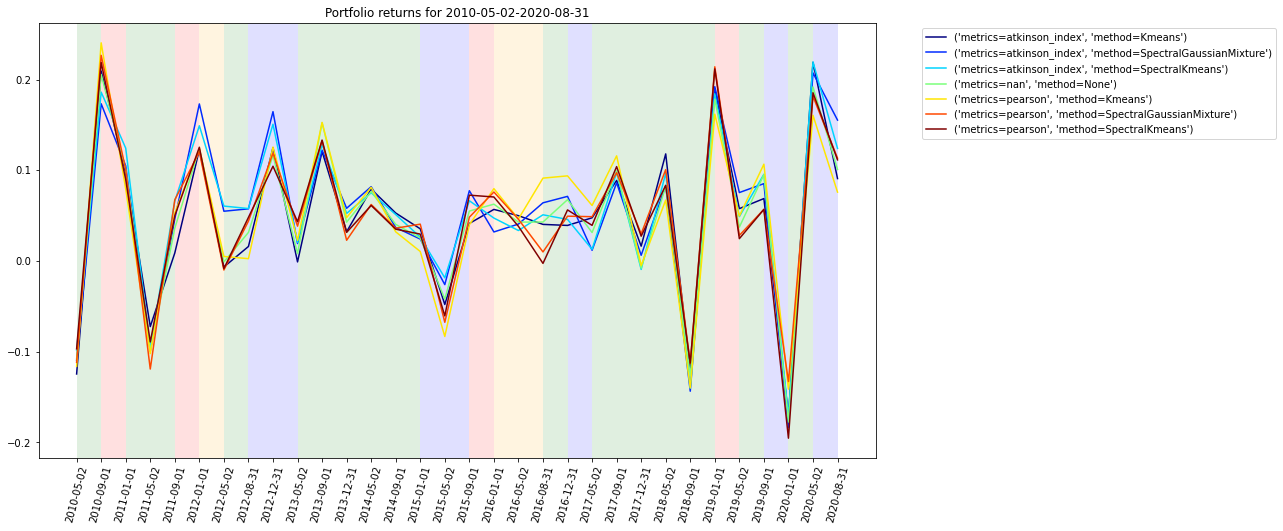

In [51]:
plt.figure(figsize=(15,8))
for i, k in enumerate(results_mean.index):
    plt.plot(
        dates, 
        results_mean.loc[k], 
        label=k, 
        color=cmap(i)
    )
        
for i in range(len(dates)-1):
    plt.axvspan(dates[i], dates[i+1], facecolor=col[i], alpha=0.12)
plt.xticks(rotation=75)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f'Portfolio returns for {dates[0]}-{dates[-1]}')
plt.show()  

In [52]:
df = performance_df
df['Params'] = df.index
df[['metrics', 'method', 'portfolio_size']] = df.Params.str.split(', ',expand=True)
df = df.fillna(0)

In [53]:
df_melt = pd.melt(df.reset_index(),
                  id_vars=['metrics', 'method', 'portfolio_size'], 
                  value_vars=['volatility',
                              'calmar_ratio',
                               'sharpe_ratio',
                               'sortino_ratio',
                               'max_drawdown'])

df_melt.columns = ['metrics', 'method', 'portfolio_size', 'performance_metrics', 'value']

In [54]:
df_melt.head()

,metrics,method,portfolio_size,performance_metrics,value
0,metrics=pearson,method=None,portfolio_size=3,volatility,0.121560
1,metrics=pearson,method=None,portfolio_size=4,volatility,0.116588
2,metrics=pearson,method=None,portfolio_size=6,volatility,0.089234
3,metrics=pearson,method=None,portfolio_size=8,volatility,0.099253
4,metrics=pearson,method=None,portfolio_size=10,volatility,0.101001


Let's have a look at the distribution of performance metrics values.

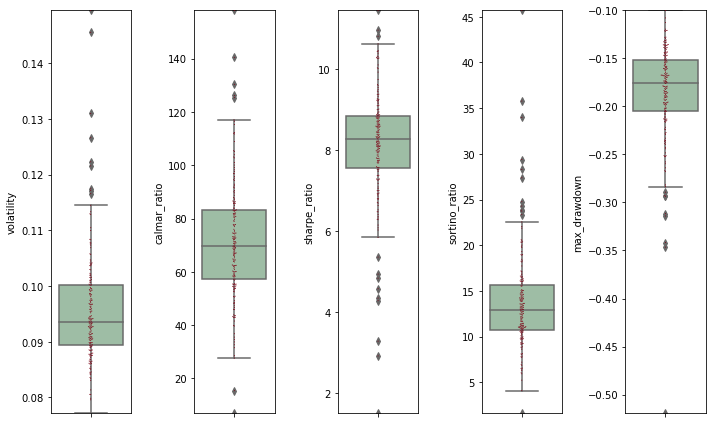

In [64]:
selection = ['volatility',
             'calmar_ratio',
             'sharpe_ratio',
             'sortino_ratio',
             'max_drawdown']
fig, axes = plt.subplots(1, len(selection), figsize=(10,6))
for i, col in enumerate(selection):
    ax = sns.boxplot(y=df[col], ax=axes.flatten()[i], color='#99c2a2')
    ax = sns.swarmplot(y=df[col], ax=axes.flatten()[i], color='#7d0013', size=1)
    ax.set_ylim(df[col].min(), df[col].max())
    ax.set_ylabel(col)
plt.tight_layout()
plt.show()

We can also conduct different variations of ANOVA to estimate the importance of different methods of portfolio selection

In [67]:
fvalue, pvalue = stats.f_oneway(
    df['volatility'], 
    df['calmar_ratio'], 
    df['sharpe_ratio'], 
    df['sortino_ratio'], 
    df['max_drawdown']
    )
print(f'F-value: {fvalue},\np-value: {pvalue}')

F-value: 1733.273514838168,
p-value: 0.0


In [68]:
# get ANOVA table as R like output
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
dep = ['metrics', 'method', 'portfolio_size']


In [69]:
# Ordinary Least Squares (OLS) model
model = ols(f'value ~ C(metrics)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(metrics),32.642729,1.0,0.039413,0.842673
Residual,826563.406729,998.0,NaN,NaN


In [70]:
model = ols(f'value ~ C(method)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(method),1300.393885,3.0,0.523123,0.666458
Residual,825295.655573,996.0,NaN,NaN


In [71]:
model = ols(f'value ~ C(portfolio_size)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(portfolio_size),5101.075648,24.0,0.252261,0.999916
Residual,821494.973810,975.0,NaN,NaN


In [72]:
# ANOVA table using bioinfokit v1.0.3 or later (it uses wrapper script for anova_lm)
res = stat()
res.anova_stat(df=df_melt, res_var='value', anova_model=f'value ~ C(metrics)')
res_an = res.anova_summary
res_an

,df,sum_sq,mean_sq,F,PR(>F)
C(metrics),1.0,32.642729,32.642729,0.039413,0.842673
Residual,998.0,826563.406729,828.219846,NaN,NaN


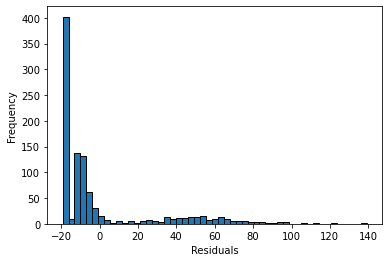

In [73]:
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

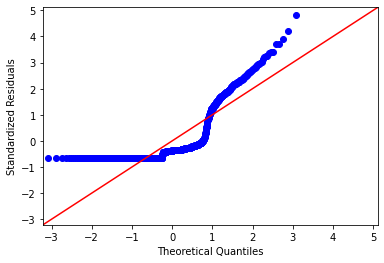

In [75]:
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

In [76]:
res = stat()
res.anova_stat(df=df_melt, res_var='value', anova_model=f'value ~ C(method)')
res_an = res.anova_summary
res_an

,df,sum_sq,mean_sq,F,PR(>F)
C(method),3.0,1300.393885,433.464628,0.523123,0.666458
Residual,996.0,825295.655573,828.610096,NaN,NaN


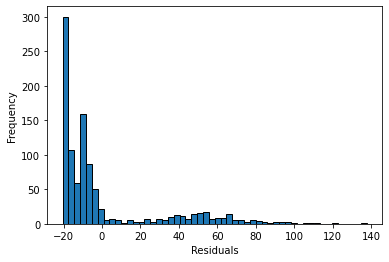

In [77]:
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

In [79]:
res = stat()
res.anova_stat(df=df_melt, res_var='value', anova_model=f'value ~ C(portfolio_size)')
res_an = res.anova_summary
res_an

,df,sum_sq,mean_sq,F,PR(>F)
C(portfolio_size),24.0,5101.075648,212.544819,0.252261,0.999916
Residual,975.0,821494.973810,842.558947,NaN,NaN


In [81]:
# perform multiple pairwise comparison (Tukey's HSD)
res = stat()
res.tukey_hsd(df=df_melt, res_var='value', xfac_var='metrics', 
              anova_model=f'value ~ C(metrics)')
res_tuk_var = res.tukey_summary
res_tuk_var

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,metrics=pearson,metrics=atkinson_index,0.361346,-3.210378,3.93307,0.28076,0.846938


In [83]:
res = stat()
res.tukey_hsd(df=df_melt, res_var='value', xfac_var='method', 
              anova_model=f'value ~ C(method)')
res_tuk_var = res.tukey_summary
res_tuk_var

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,method=None,method=Kmeans,1.608360,-5.017265,8.233985,0.883442,0.900000
1,method=None,method=SpectralKmeans,1.594175,-5.031450,8.219800,0.875651,0.900000
2,method=None,method=SpectralGaussianMixture,3.225320,-3.400305,9.850945,1.771608,0.582205
3,method=Kmeans,method=SpectralKmeans,0.014185,-6.611440,6.639811,0.007792,0.900000
4,method=Kmeans,method=SpectralGaussianMixture,1.616960,-5.008665,8.242585,0.888166,0.900000
5,method=SpectralKmeans,method=SpectralGaussianMixture,1.631145,-4.994480,8.256770,0.895958,0.900000


In [84]:
res = stat()
res.tukey_hsd(df=df_melt, res_var='value', xfac_var='portfolio_size', 
              anova_model=f'value ~ C(portfolio_size)')
res_tuk_var = res.tukey_summary
res_tuk_var

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,portfolio_size=3,portfolio_size=4,6.031928,-17.780582,29.844438,1.314274,0.9
1,portfolio_size=3,portfolio_size=6,11.431290,-12.381220,35.243800,2.490721,0.9
2,portfolio_size=3,portfolio_size=8,10.618755,-13.193755,34.431265,2.313681,0.9
3,portfolio_size=3,portfolio_size=10,7.064787,-16.747723,30.877297,1.539320,0.9
4,portfolio_size=3,portfolio_size=12,6.114621,-17.697889,29.927131,1.332292,0.9
...,...,...,...,...,...,...,...
295,portfolio_size=44,portfolio_size=48,1.792324,-22.020186,25.604834,0.390523,0.9
296,portfolio_size=44,portfolio_size=50,2.387055,-21.425455,26.199565,0.520106,0.9
297,portfolio_size=46,portfolio_size=48,2.713713,-21.098797,26.526223,0.591281,0.9
298,portfolio_size=46,portfolio_size=50,3.308444,-20.504066,27.120954,0.720865,0.9


In [85]:
res = stat()
res.levene(df=df_melt, res_var='value', xfac_var='metrics', center='trimmed')
metr_lev = res.levene_summary
metr_lev

,Parameter,Value
0,Test statistics (W),0.1595
1,Degrees of freedom (Df),1.0000
2,p value,0.6897


In [86]:
res = stat()
res.levene(df=df_melt, res_var='value', xfac_var='method', center='trimmed')
method_lev = res.levene_summary
method_lev

,Parameter,Value
0,Test statistics (W),1.6447
1,Degrees of freedom (Df),3.0000
2,p value,0.1775


In [87]:
res = stat()
res.levene(df=df_melt, res_var='value', xfac_var='portfolio_size', center='trimmed')
size_lev = res.levene_summary
size_lev

,Parameter,Value
0,Test statistics (W),0.7927
1,Degrees of freedom (Df),24.0000
2,p value,0.7490
